/Users/ytcheng/anaconda3/lib/python3.5/site-packages/astropy/units/quantity.py:641: RuntimeWarning: invalid value encountered in true_divide
  *arrays, **kwargs)
/Users/ytcheng/anaconda3/lib/python3.5/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


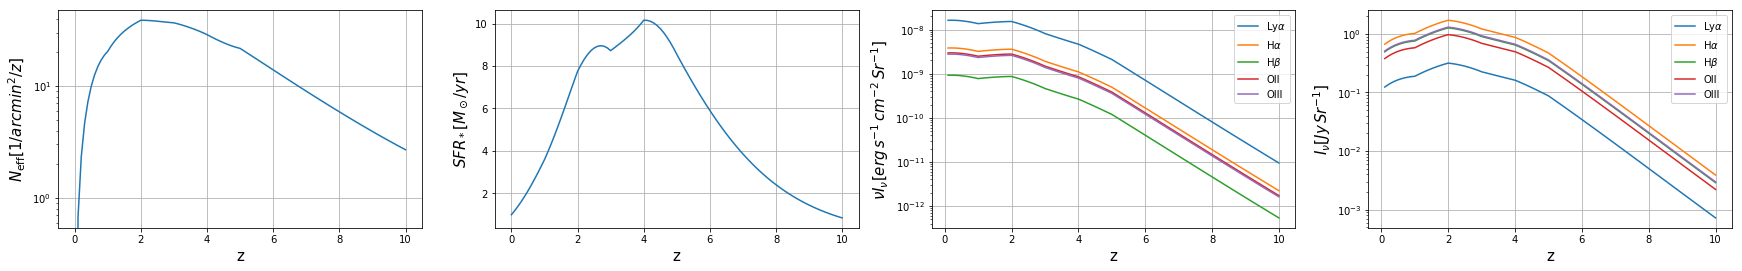

In [131]:
#
from model_F17 import *

dz = 0.1
zbins = np.arange(0,10 + dz,dz)

Neff_arr = np.zeros_like(zbins)
sfrs_arr = np.zeros_like(zbins)
Las_arr = np.zeros_like(zbins)
Has_arr = np.zeros_like(zbins)
Hbs_arr = np.zeros_like(zbins)
O2s_arr = np.zeros_like(zbins)
O3s_arr = np.zeros_like(zbins)

Neffcmv_arr = np.zeros_like(zbins)

df = pd.DataFrame(zbins, columns=['z'])
for i,z in enumerate(zbins):
    Neff = Neff_F17(z, unit = 'obs')
    Neffcmv = Neff_F17(z, unit = 'cmv')
    sfrs = SFRs_F17(z)
    Neff_arr[i] = Neff
    Neffcmv_arr[i] = Neffcmv
    sfrs_arr[i] = sfrs
    Las_arr[i] = Lline_F17('Lya', z, sfr_arr = [sfrs])[0][0]
    Has_arr[i] = Lline_F17('Ha', z, sfr_arr = [sfrs])[0][0]
    Hbs_arr[i] = Lline_F17('Hb', z, sfr_arr = [sfrs])[0][0]
    O2s_arr[i] = Lline_F17('OII', z, sfr_arr = [sfrs])[0][0]
    O3s_arr[i] = Lline_F17('OIII', z, sfr_arr = [sfrs])[0][0]
    
df['Neff'] = Neff_arr
df['SFRs'] = sfrs_arr
df['Lya_Ls'] = Las_arr
df['Ha_Ls'] = Has_arr
df['Hb_Ls'] = Hbs_arr
df['OII_Ls'] = O2s_arr
df['OIII_Ls'] = O3s_arr

df.to_csv('data_internal/F17NeffSFRs.txt',index=False)


# make a plot to compare with F17 paper
fig, ax = plt.subplots(1,4,figsize = (30,4))
ax[0].plot(zbins, Neff_arr)
ax[0].set_yscale('log')
ax[0].set_xlabel('z', fontsize = 15)
ax[0].set_ylabel(r'$N_{\rm eff} [1/arcmin^2/z]$' ,fontsize = 15)
ax[0].grid()
ax[1].plot(zbins, sfrs_arr)
ax[1].set_xlabel('z', fontsize = 15)
ax[1].set_ylabel(r'$SFR_* [M_\odot / yr]$' ,fontsize = 15)
ax[1].grid()

# calculate nuInu
# Inu = (Ls * Neff) *  DA^2 y / (4pi DL^2)
# y = lambda_obs (1+z) / H(z)
# nuInu = (Ls * Neff) *(c * Da^2 * (1+z)) / (4pi * DL^2 * H(z))

cd = cosmo_dist(zbins)
c = const.c * (1 + zbins) * cd.comoving_distance**2 \
    / (cd.H * cosmo.luminosity_distance(zbins)**2 * 4 * np.pi) / u.sr
c = c.to(u.Mpc**3 / u.h**3 / u.sr / u.cm**2)

nuInu_arr = c * (Neffcmv_arr * u.h**3 / u.Mpc**3) * (Las_arr * u.L_sun).to(u.erg / u.second)
ax[2].plot(zbins, nuInu_arr.value, label = r'Ly$\alpha$')
nuInu_arr = c * (Neffcmv_arr * u.h**3 / u.Mpc**3) * (Has_arr * u.L_sun).to(u.erg / u.second)
ax[2].plot(zbins, nuInu_arr.value, label = r'H$\alpha$')
nuInu_arr = c * (Neffcmv_arr * u.h**3 / u.Mpc**3) * (Hbs_arr * u.L_sun).to(u.erg / u.second)
ax[2].plot(zbins, nuInu_arr.value, label = r'H$\beta$')
nuInu_arr = c * (Neffcmv_arr * u.h**3 / u.Mpc**3) * (O2s_arr * u.L_sun).to(u.erg / u.second)
ax[2].plot(zbins, nuInu_arr.value, label = 'OII')
nuInu_arr = c * (Neffcmv_arr * u.h**3 / u.Mpc**3) * (O3s_arr * u.L_sun).to(u.erg / u.second)
ax[2].plot(zbins, nuInu_arr.value, label = 'OIII')
ax[2].set_yscale('log')
ax[2].set_xlabel('z', fontsize = 15)
ax[2].set_ylabel(r'$\nu I_\nu [erg\,s^{-1}\,cm^{-2}\,Sr^{-1}]$' ,fontsize = 15)
ax[2].legend(loc = 0)
ax[2].grid()

nu_obs = (spec_lines.Lya.to(u.GHz, equivalencies = u.spectral()) / (1 + zbins))
I_arr = nuInu_arr.to(u.Jy * u.GHz / u.sr) / nu_obs
ax[3].plot(zbins, I_arr.value, label = r'Ly$\alpha$')
nu_obs = (spec_lines.Ha.to(u.GHz, equivalencies = u.spectral()) / (1 + zbins))
I_arr = nuInu_arr.to(u.Jy * u.GHz / u.sr) / nu_obs
ax[3].plot(zbins, I_arr.value, label = r'H$\alpha$')
nu_obs = (spec_lines.Hb.to(u.GHz, equivalencies = u.spectral()) / (1 + zbins))
I_arr = nuInu_arr.to(u.Jy * u.GHz / u.sr) / nu_obs
ax[3].plot(zbins, I_arr.value, label = r'H$\beta$')
nu_obs = (spec_lines.OII.to(u.GHz, equivalencies = u.spectral()) / (1 + zbins))
I_arr = nuInu_arr.to(u.Jy * u.GHz / u.sr) / nu_obs
ax[3].plot(zbins, I_arr.value, label = r'OII')
nu_obs = (spec_lines.OIII.to(u.GHz, equivalencies = u.spectral()) / (1 + zbins))
I_arr = nuInu_arr.to(u.Jy * u.GHz / u.sr) / nu_obs
ax[3].plot(zbins, I_arr.value, label = r'OIII')
ax[3].set_yscale('log')
ax[3].set_xlabel('z', fontsize = 15)
ax[3].set_ylabel(r'$I_\nu [Jy\,Sr^{-1}]$' ,fontsize = 15)
ax[3].legend(loc = 0)
ax[3].grid()

/Users/ytcheng/anaconda3/lib/python3.5/site-packages/astropy/units/quantity.py:641: RuntimeWarning: invalid value encountered in true_divide
  *arrays, **kwargs)
/Users/ytcheng/anaconda3/lib/python3.5/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


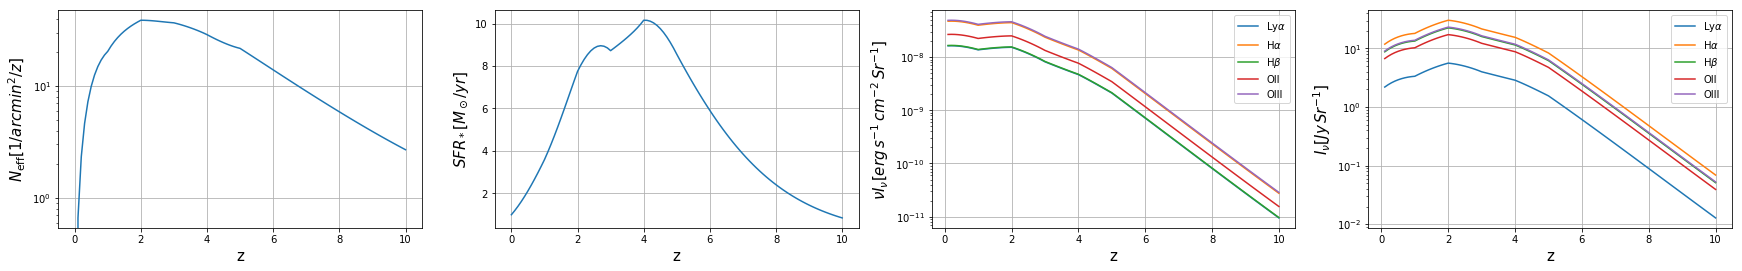

In [2]:
#
from model_F17 import *

dz = 0.1
zbins = np.arange(0,10 + dz,dz)

Neff_arr = np.zeros_like(zbins)
sfrs_arr = np.zeros_like(zbins)
Las_arr = np.zeros_like(zbins)
Has_arr = np.zeros_like(zbins)
Hbs_arr = np.zeros_like(zbins)
O2s_arr = np.zeros_like(zbins)
O3s_arr = np.zeros_like(zbins)

Neffcmv_arr = np.zeros_like(zbins)

df = pd.DataFrame(zbins, columns=['z'])
for i,z in enumerate(zbins):
    Neff = Neff_F17(z, unit = 'obs')
    Neffcmv = Neff_F17(z, unit = 'cmv')
    sfrs = SFRs_F17(z)
    Neff_arr[i] = Neff
    Neffcmv_arr[i] = Neffcmv
    sfrs_arr[i] = sfrs
    Las_arr[i] = Lline_F17('Lya', z, sfr_arr = [sfrs])[0][0]
    Has_arr[i] = Lline_G17('Ha', z, sfr_arr = [sfrs])[0][0]
    Hbs_arr[i] = Lline_G17('Hb', z, sfr_arr = [sfrs])[0][0]
    O2s_arr[i] = Lline_G17('OII', z, sfr_arr = [sfrs])[0][0]
    O3s_arr[i] = Lline_G17('OIII', z, sfr_arr = [sfrs])[0][0]
    
df['Neff'] = Neff_arr
df['SFRs'] = sfrs_arr
df['Lya_Ls'] = Las_arr
df['Ha_Ls'] = Has_arr
df['Hb_Ls'] = Hbs_arr
df['OII_Ls'] = O2s_arr
df['OIII_Ls'] = O3s_arr

df.to_csv('data_internal/F17NeffSFRs.txt',index=False)


# make a plot to compare with F17 paper
fig, ax = plt.subplots(1,4,figsize = (30,4))
ax[0].plot(zbins, Neff_arr)
ax[0].set_yscale('log')
ax[0].set_xlabel('z', fontsize = 15)
ax[0].set_ylabel(r'$N_{\rm eff} [1/arcmin^2/z]$' ,fontsize = 15)
ax[0].grid()
ax[1].plot(zbins, sfrs_arr)
ax[1].set_xlabel('z', fontsize = 15)
ax[1].set_ylabel(r'$SFR_* [M_\odot / yr]$' ,fontsize = 15)
ax[1].grid()

# calculate nuInu
# Inu = (Ls * Neff) *  DA^2 y / (4pi DL^2)
# y = lambda_obs (1+z) / H(z)
# nuInu = (Ls * Neff) *(c * Da^2 * (1+z)) / (4pi * DL^2 * H(z))

cd = cosmo_dist(zbins)
c = const.c * (1 + zbins) * cd.comoving_distance**2 \
    / (cd.H * cosmo.luminosity_distance(zbins)**2 * 4 * np.pi) / u.sr
c = c.to(u.Mpc**3 / u.h**3 / u.sr / u.cm**2)

nuInu_arr = c * (Neffcmv_arr * u.h**3 / u.Mpc**3) * (Las_arr * u.L_sun).to(u.erg / u.second)
ax[2].plot(zbins, nuInu_arr.value, label = r'Ly$\alpha$')
nuInu_arr = c * (Neffcmv_arr * u.h**3 / u.Mpc**3) * (Has_arr * u.L_sun).to(u.erg / u.second)
ax[2].plot(zbins, nuInu_arr.value, label = r'H$\alpha$')
nuInu_arr = c * (Neffcmv_arr * u.h**3 / u.Mpc**3) * (Hbs_arr * u.L_sun).to(u.erg / u.second)
ax[2].plot(zbins, nuInu_arr.value, label = r'H$\beta$')
nuInu_arr = c * (Neffcmv_arr * u.h**3 / u.Mpc**3) * (O2s_arr * u.L_sun).to(u.erg / u.second)
ax[2].plot(zbins, nuInu_arr.value, label = 'OII')
nuInu_arr = c * (Neffcmv_arr * u.h**3 / u.Mpc**3) * (O3s_arr * u.L_sun).to(u.erg / u.second)
ax[2].plot(zbins, nuInu_arr.value, label = 'OIII')
ax[2].set_yscale('log')
ax[2].set_xlabel('z', fontsize = 15)
ax[2].set_ylabel(r'$\nu I_\nu [erg\,s^{-1}\,cm^{-2}\,Sr^{-1}]$' ,fontsize = 15)
ax[2].legend(loc = 0)
ax[2].grid()

nu_obs = (spec_lines.Lya.to(u.GHz, equivalencies = u.spectral()) / (1 + zbins))
I_arr = nuInu_arr.to(u.Jy * u.GHz / u.sr) / nu_obs
ax[3].plot(zbins, I_arr.value, label = r'Ly$\alpha$')
nu_obs = (spec_lines.Ha.to(u.GHz, equivalencies = u.spectral()) / (1 + zbins))
I_arr = nuInu_arr.to(u.Jy * u.GHz / u.sr) / nu_obs
ax[3].plot(zbins, I_arr.value, label = r'H$\alpha$')
nu_obs = (spec_lines.Hb.to(u.GHz, equivalencies = u.spectral()) / (1 + zbins))
I_arr = nuInu_arr.to(u.Jy * u.GHz / u.sr) / nu_obs
ax[3].plot(zbins, I_arr.value, label = r'H$\beta$')
nu_obs = (spec_lines.OII.to(u.GHz, equivalencies = u.spectral()) / (1 + zbins))
I_arr = nuInu_arr.to(u.Jy * u.GHz / u.sr) / nu_obs
ax[3].plot(zbins, I_arr.value, label = r'OII')
nu_obs = (spec_lines.OIII.to(u.GHz, equivalencies = u.spectral()) / (1 + zbins))
I_arr = nuInu_arr.to(u.Jy * u.GHz / u.sr) / nu_obs
ax[3].plot(zbins, I_arr.value, label = r'OIII')
ax[3].set_yscale('log')
ax[3].set_xlabel('z', fontsize = 15)
ax[3].set_ylabel(r'$I_\nu [Jy\,Sr^{-1}]$' ,fontsize = 15)
ax[3].legend(loc = 0)
ax[3].grid()

Text(0,0.5,'log10(SFRD)[$M_\\odot$/ yr / Mpc$^3$]')

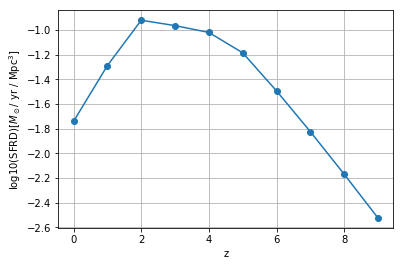

In [1]:
# F17 SFRD

from model_F17 import *

z_arr = np.arange(10, dtype = 'float')
sfrd_arr = np.zeros_like(z_arr)
for i,z in enumerate(z_arr):
    sfrd_arr[i] = SFRD_F17(z)
sfrd_arr *= cosmo.h**3
plt.plot(z_arr, np.log10(sfrd_arr),'o-')
plt.grid()
plt.xlabel('z')
plt.ylabel('log10(SFRD)[$M_\odot$/ yr / Mpc$^3$]')

In [6]:
from survey_params import *
sphx_par = spherex_param()

line = 'Ha'
for line in ('Ha', 'OII', 'OIII'):
    LperSFR_F = Lline_F17(line, 0, sfr_arr = [1])[0][0] * u.Lsun.to(u.erg / u.s)
    LperSFR_G = Lline_G17(line, 0, sfr_arr = [1])[0][0] * u.Lsun.to(u.erg / u.s)
    ratio = LperSFR_G/LperSFR_F
    print('%s, L(G17) / L(F17) = %.2f'%(line, ratio))

Ha, L(G17) / L(F17) = 12.35
OII, L(G17) / L(F17) = 8.99
OIII, L(G17) / L(F17) = 17.72


In [7]:
# Ha L* at z = 2.23

z = 2.23
Ls_Sobral = 10**42.87 # erg / s
sfrs = SFRs_F17(z)
Ls_F = Lline_F17('Ha', z, sfr_arr = [sfrs])[0][0] * u.Lsun.to(u.erg / u.s)
Ls_G = Lline_G17('Ha', z, sfr_arr = [sfrs])[0][0] * u.Lsun.to(u.erg / u.s)
print('L*(F17) = %.2e, L*(G17) = %.2e, L*(Sobral) = %.2e'%(Ls_F, Ls_G, Ls_Sobral))

dOm = ((6.2 / 60 / 60)*(np.pi/180))**2 * u.steradian

nu_obs = spec_lines.Ha.to(u.GHz, equivalencies = u.spectral()).value / (1 + z)
idx = np.argmin(abs(sphx_par.nu_bins - nu_obs))
dnu = sphx_par.dnus[idx] * u.GHz

DL = cosmo.luminosity_distance(z)
I_Sobral = (Ls_Sobral * (u.erg / u.s) / 4 / np.pi / DL**2 / dnu / dOm).to(u.Jy / u.sr)
I_F = (Ls_F * (u.erg / u.s) / 4 / np.pi / DL**2 / dnu / dOm).to(u.Jy / u.sr)
I_G = (Ls_G * (u.erg / u.s) / 4 / np.pi / DL**2 / dnu / dOm).to(u.Jy / u.sr)
I_n = 3631 * 10**(-22  /2.5) * u.Jy / 5 / dOm

print('I*(Sobral) = %.2f, I*(F17) = %.2f, I*(G17) = %.2f, In = %.2f'\
      %(I_Sobral.value, I_F.value, I_G.value, I_n.value))

L*(F17) = 8.60e+40, L*(G17) = 1.06e+42, L*(Sobral) = 7.41e+42
I*(Sobral) = 6015.20, I*(F17) = 69.75, I*(G17) = 861.19, In = 1273.86
